<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/Class_wise_difficulty_balanced_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://github.com/hitachi-rd-cv/CDB-loss/tree/143ea5c17c237c71cfbf0a7f2df66a4009394cdc

In [ ]:
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [ ]:
use_cuda = torch.cuda.is_available()

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# load data
test_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
train_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose(train_seq)
train_dataset = torchvision.datasets.MNIST(
    ".", train=True, download=True, transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".", train=False, transform=test_transform),
    batch_size=500,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 25844853.49it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122980399.82it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28272209.72it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 87044213.82it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119228045.10it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48621283.72it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20032101.75it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


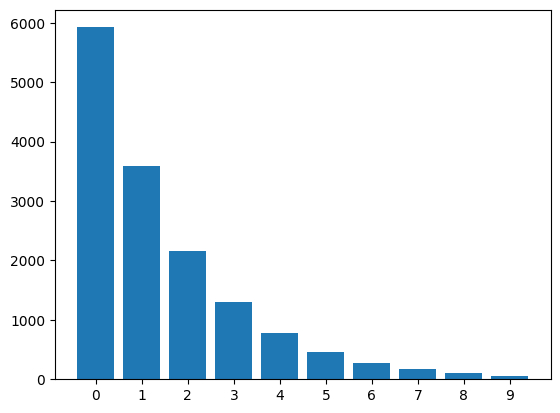

In [ ]:
trainset = torchvision.datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1302,), (0.3069,)),
        ]
    ),
)


# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
torch.manual_seed(seed)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64
)

print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


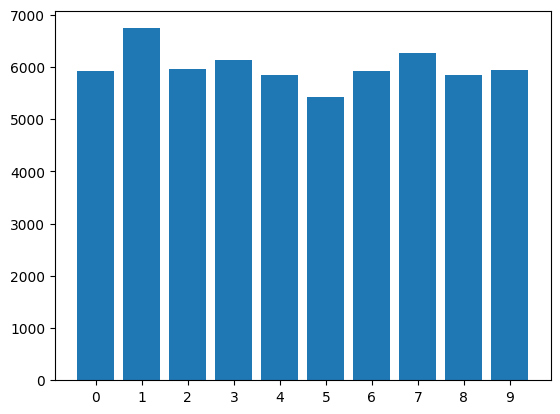

Sampling probability for each class:


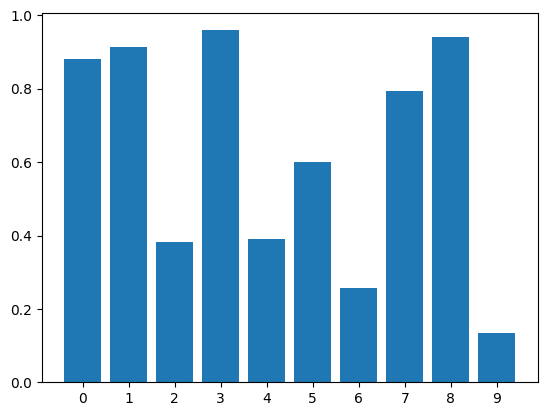

Imbalanced dataset: 14809 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


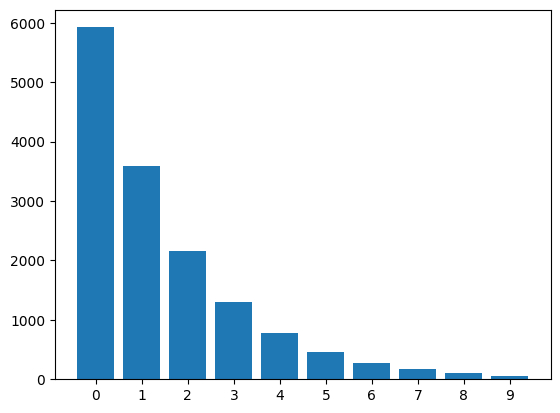

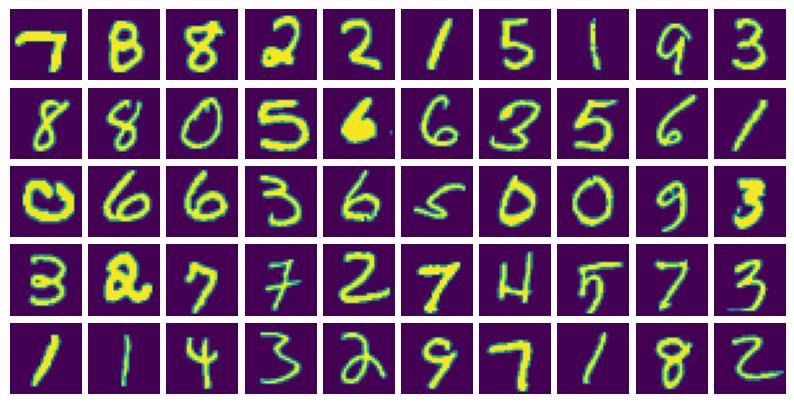

In [ ]:
def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis("off")

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()


def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%" % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, "g")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", annot_kws={"size": 10})
    plt.show()
    return annot


print(
    "Original dataset: %d training samples & %d testing samples\n"
    % (len(train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print("Sampling probability for each class:")
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print(
    "Imbalanced dataset: %d training samples & %d testing samples\n"
    % (len(imbalanced_train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))

valid_samples = SubsetRandomSampler(indices[:split])
train_samples = SubsetRandomSampler(indices[split:])

# Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=train_samples, batch_size=64
)
imbalanced_val_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, sampler=valid_samples, batch_size=64
)

In [ ]:
class ClassDifficultyBalancedLoss(torch.nn.Module):
    def __init__(self, class_difficulty, tau):
        super().__init__()
        print("class_difficulty: ", class_difficulty)
        self.class_difficulty = class_difficulty
        self.weights = self.class_difficulty ** float(tau)
        self.weights = self.weights / (self.weights.sum() * len(self.weights))
        self.weights = torch.from_numpy(self.weights).float().to(device)
        print("self.weights: ", self.weights)
        self.loss = torch.nn.NLLLoss(
            weight=self.weights
        )  # need to use NLLLoss here instead

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        return self.loss(input, target)

In [ ]:
from collections import Counter


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def process(train_loader, valid_loader, test_loader, lossCriterion, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if lossCriterion == torch.nn.NLLLoss:
        print("loss is torch.nn.NLLLoss")
        criterion = lossCriterion().to(device)
    else:
        print("entres")
        class_difficulty = np.ones(num_classes)
        criterion = lossCriterion(class_difficulty, tau=1.5).to(device)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def validate(val_loader):
        model.eval()
        val_total = 0
        val_loss = 0
        class_wise_accuracy = np.zeros(10)  # number of classes = 10
        val_samples_per_class = np.zeros(10)
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            with torch.no_grad():
                out = model(val_images)
            _, val_predicted = out.max(1)
            # print('val_predicted: ', val_predicted)
            val_total += val_labels.size(0)
            for id in range(len(val_predicted)):
                if val_predicted[id] == val_labels[id]:
                    class_wise_accuracy[int(val_predicted[id])] += 1
            for label in val_labels:
                val_samples_per_class[label] += 1

        print("class_wise_accuracy is: ", class_wise_accuracy)
        class_wise_accuracy = class_wise_accuracy / val_samples_per_class
        print("after normalization, class_wise_accuracy is: ", class_wise_accuracy)
        return class_wise_accuracy

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(1, 20 + 1):
        train(train_loader)

        class_wise_accuracy = validate(valid_loader)

        if lossCriterion == ClassDifficultyBalancedLoss:
            print("enters")
            criterion = ClassDifficultyBalancedLoss(
                class_difficulty=1 - class_wise_accuracy, tau=1.5
            ).to(device)  # tau =  0.5, 1, 1.5, 2, 5,

        val_accuracy = class_wise_accuracy.mean()
        print("Validation: val accuracy = %.4f" % (val_accuracy))

        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    # vis(test_accs, confusion_mtxes, classe_labels)
    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

loss is torch.nn.NLLLoss
class_wise_accuracy is:  [1156.  720.  370.  185.  121.    0.    0.    0.    0.    0.]
after normalization, class_wise_accuracy is:  [0.98550725 0.99037139 0.87885986 0.74596774 0.76100629 0.
 0.         0.         0.         0.        ]
Validation: val accuracy = 0.4362
Best test acc = 45.55%
class_wise_accuracy is:  [1160.  720.  380.  214.  148.   58.   22.    7.    0.    0.]
after normalization, class_wise_accuracy is:  [0.98891731 0.99037139 0.90261283 0.86290323 0.93081761 0.54205607
 0.37931034 0.18918919 0.         0.        ]
Validation: val accuracy = 0.5786
Best test acc = 60.11%
class_wise_accuracy is:  [1152.  721.  396.  222.  144.   60.   42.   22.    0.    0.]
after normalization, class_wise_accuracy is:  [0.98209719 0.99174691 0.94061758 0.89516129 0.90566038 0.56074766
 0.72413793 0.59459459 0.         0.        ]
Validation: val accuracy = 0.6595
Best test acc = 67.42%
class_wise_accuracy is:  [1.16e+03 7.17e+02 3.97e+02 2.21e+02 1.44e+02 7.3

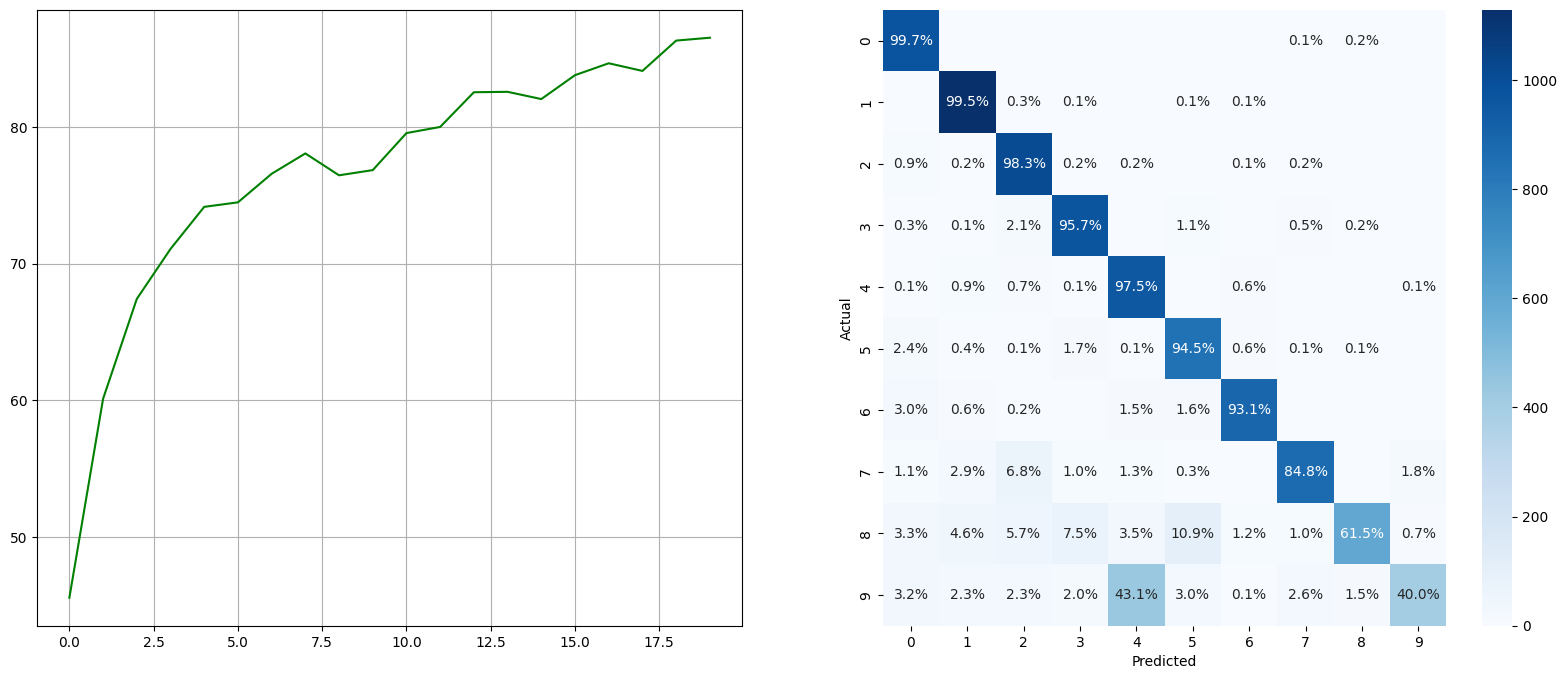

In [ ]:
# baseline of torch.nn.CrossEntropyLoss
test_acc_crossentropy, confusion_mtx_crossentropy = process(
    imbalanced_train_loader, imbalanced_val_loader, test_loader, torch.nn.NLLLoss
)

entres
class_difficulty:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
self.weights:  tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], device='cuda:0')
class_wise_accuracy is:  [1.16e+03 7.22e+02 3.75e+02 1.81e+02 1.13e+02 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 0.00e+00]
after normalization, class_wise_accuracy is:  [0.98891731 0.99312242 0.89073634 0.72983871 0.71069182 0.01869159
 0.01724138 0.         0.         0.        ]
enters
class_difficulty:  [0.01108269 0.00687758 0.10926366 0.27016129 0.28930818 0.98130841
 0.98275862 1.         1.         1.        ]
self.weights:  tensor([2.2096e-05, 1.0802e-05, 6.8401e-04, 2.6594e-03, 2.9471e-03, 1.8410e-02,
        1.8451e-02, 1.8939e-02, 1.8939e-02, 1.8939e-02], device='cuda:0')
Validation: val accuracy = 0.4349
Best test acc = 45.88%
class_wise_accuracy is:  [172. 319. 386. 219. 131. 103.  53.  31.   1.   2.]
after normalization, class_wise_accuracy is:  [0.14663257 0.43878955 0.91686461 0.88306452 0.8

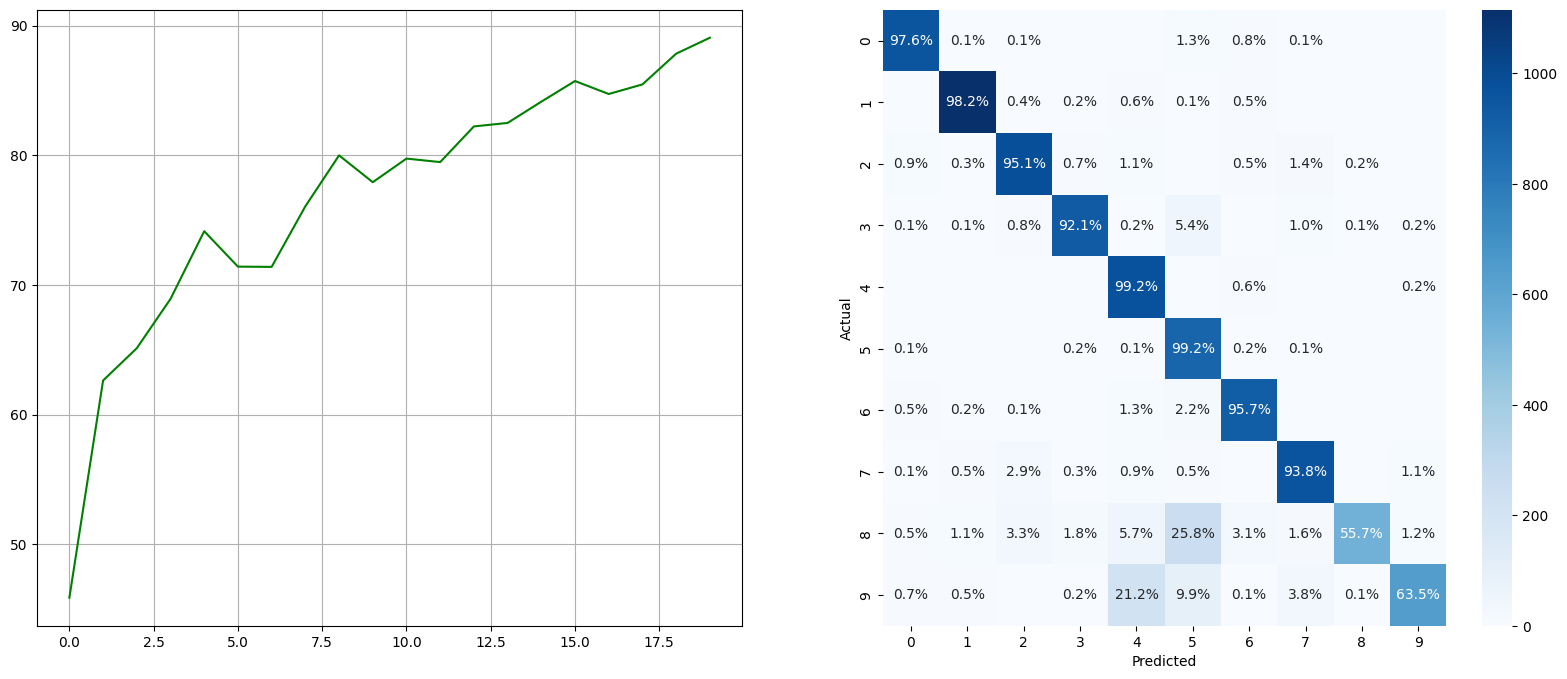

In [ ]:
test_acc_CDB, confusion_mtx_CDB = process(
    imbalanced_train_loader,
    imbalanced_val_loader,
    test_loader,
    ClassDifficultyBalancedLoss,
)

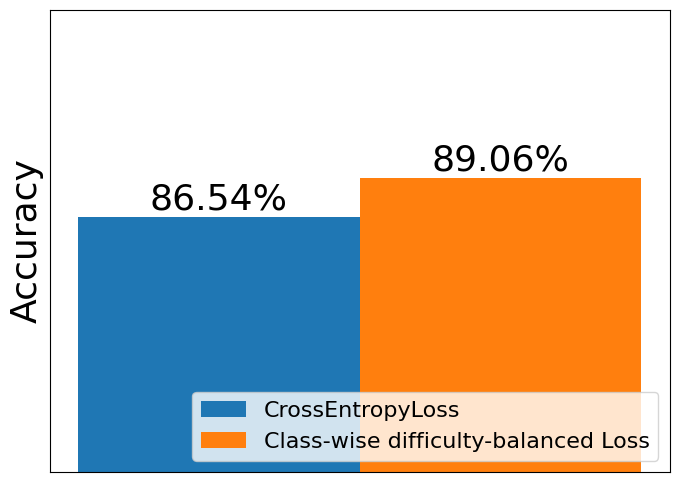

In [ ]:
fig = plt.subplots(figsize=(8, 6))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(test_acc_crossentropy).astype(float),
    width=0.1,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(test_acc_CDB).astype(float),
    width=0.1,
    label="Class-wise difficulty-balanced Loss",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.legend(loc="lower right")
plt.ylabel("Accuracy", fontsize=26)
plt.legend(loc="lower right", fontsize=16)
plt.show()

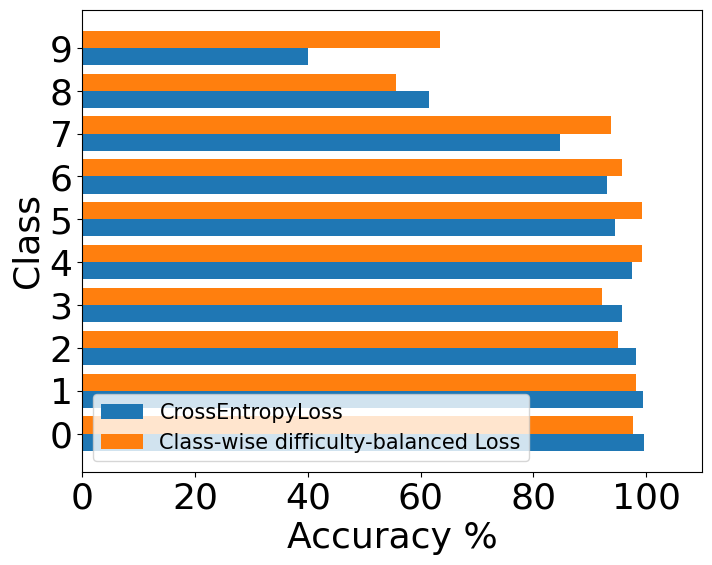

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages_CDB = [confusion_mtx_CDB[i][i][:-1] for i in range(10)]

p1 = plt.barh(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    height=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.barh(
    br2,
    np.array(class_percentages_CDB).astype(float),
    height=0.4,
    label="Class-wise difficulty-balanced Loss",
)

plt.yticks(
    [r + 0.2 for r in range(10)],
    ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    fontsize=26,
)
plt.xlim(0, 110)
plt.xticks(fontsize=26)
plt.legend(loc="lower left")
plt.ylabel("Class", fontsize=26)
plt.xlabel("Accuracy %", fontsize=26)
plt.legend(loc="lower left", fontsize=15)
plt.show()

In [ ]:
df = pd.DataFrame(
    {
        "CrossEntropyLoss": class_percentages_crossentropy,
        "CDBLoss": class_percentages_CDB,
    },
    index=range(10),
)
df

,CrossEntropyLoss,CDBLoss
0,99.7,97.6
1,99.5,98.2
2,98.3,95.1
3,95.7,92.1
4,97.5,99.2
5,94.5,99.2
6,93.1,95.7
7,84.8,93.8
8,61.5,55.7
9,40.0,63.5
